# CS231n in Tensorflow: Assignment 1 q3: Softmax 

This is an exercise of implementing [CS231n assignment 1](http://cs231n.github.io/assignments2016/assignment1/) using [Tensorflow](https://www.tensorflow.org/) instead of doing it by hand in numpy. 

See my [cs231n assignment 1](https://github.com/krosaen/cs231n/tree/master/assignment1) directory for more context and pointers to my solutions to the original assignment; this is an additional exercise I'm doing to make sense of Tensorflow along the way.

## Loading the dataset

(Some of the original code has been modifed to be python3 friendly.)

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [13]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev, mean_image = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


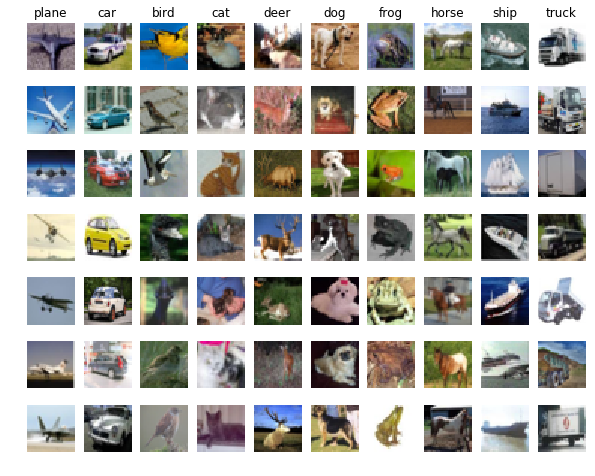

In [15]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # note we need to remove bias term and add back the mean image to see 
        # original
        original_image = X_train[idx][:-1] + mean_image
        plt.imshow(original_image.reshape((32, 32, 3)).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Tensorflow model

I'm basically trying to reproduce what we did in the other notebook, following some of the patterns outlined in the [TF MNIST tutorial](https://www.tensorflow.org/versions/master/get_started/mnist/beginners).

### One-hot y

The tutorial uses a one-hot encoded output vector, so let's follow suite:

In [64]:
def one_hot(a, num_classes=10):
    one_hot_a = np.zeros((a.shape[0], num_classes))
    one_hot_a[range(a.shape[0]), a] = 1
    return one_hot_a

sample = np.array([1, 2, 0, 0, 2, 1])
print("example one-hot encoding\n{}\n->\n{}".format(sample, one_hot(sample, 3)))

example one-hot encoding
[1 2 0 0 2 1]
->
[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]]


In [65]:
y_train_onehot, y_val_onehot, y_dev_onehot = [one_hot(y, 10) for y in [y_train, y_val, y_dev]]

### Defining the compute graph for training

In [73]:
import tensorflow as tf

# model params
tf_W = tf.Variable(np.random.randn(3073, 10) * 0.0001, name='W', dtype=tf.float64)
# tf_W = tf.Variable(tf.zeros([3073, 10]))

# input and output

tf_X = tf.placeholder(tf.float64, [None, 3073], name='X')
tf_scores = tf.matmul(tf_X, tf_W, name='scores')
tf_max_scores = tf.reduce_max(tf_scores, reduction_indices=[1], keep_dims=True, name='max_scores')
# normalize for numerical stability http://cs231n.github.io/linear-classify/#softmax
tf_scores_stable = tf_scores - tf_max_scores  

tf_y = tf.nn.softmax(tf_scores_stable, name='y')

# loss 
tf_y_sol = tf.placeholder(tf.float64, [None, 10], name='y_sol')
tf_loss = tf.reduce_mean(-tf.reduce_sum(tf_y_sol * tf.log(tf_y), reduction_indices=[1]), name='loss')

train_step = tf.train.GradientDescentOptimizer(0.5).minimize(tf_loss)




### Mini-batch training

In [74]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for _ in range(1500):
    batch_is = np.random.choice(X_train.shape[0], 200, replace=True)
    batch_xs, batch_ys = X_train[batch_is], y_train_onehot[batch_is]
    sess.run(train_step, feed_dict={tf_X: batch_xs, tf_y_sol: batch_ys})
    
    

### Training and validation set accuracy

In [79]:
correct_prediction = tf.equal(tf.argmax(tf_y, 1), tf.argmax(tf_y_sol, 1), name='correct_prediction')
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

In [80]:
print("training accuracy: {}".format(
    sess.run(accuracy, feed_dict={tf_X: X_train, tf_y_sol: y_train_onehot})))

training accuracy: 0.10026528686285019


In [81]:
print("test accuracy: {}".format(
    sess.run(accuracy, feed_dict={tf_X: X_val, tf_y_sol: y_val_onehot})))

test accuracy: 0.08699999749660492
